# Model Fintuning

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd

In [ ]:
training_data = pd.read_csv('Reviews_For_Finetuning.csv')
X = training_data[['Review', 'summary']].rename(columns={'Review':'input_text', 'summary':'target_text'})
dataset = Dataset.from_pandas(X)

### Finetune T5-small model with LLM soft-labeled summary data of 2000 reviews.

In [ ]:
# Model Initialize
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Preprocessing - Tokenize
def preprocess(example):
    model_inputs = tokenizer(
        example['input_text'], max_length=512, truncation=True, padding="max_length"
    )
    labels = tokenizer(
        example['target_text'], max_length=64, truncation=True, padding="max_length"
    )
    model_inputs['labels'] = labels['input_ids']
    return model_inputs
tokenized_dataset = dataset.map(preprocess)


# Model Params Setting
training_args = TrainingArguments(
    output_dir="./t5-summary-model",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=50,
    evaluation_strategy="no",
    save_total_limit=1,
    fp16=True, 
    report_to="none"
)

# Execute Finetuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset
)

trainer.train()


### T5 Finetuned Model Use Case & Summary Testing

In [14]:
model = T5ForConditionalGeneration.from_pretrained("./t5_AirlineReviews_summary_model")
tokenizer = T5Tokenizer.from_pretrained("./t5_AirlineReviews_summary_model")

def summarize(text, max_input_length=512, max_output_length=64):
    input_text = "summarize: " + text

    input_ids = tokenizer.encode(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_length
    )

    output_ids = model.generate(
        input_ids,
        max_length=max_output_length,
        num_beams=4,
        early_stopping=True
    )

    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary

test_text = X.input_text[1]
print("✈️ Original Text", test_text, end='\n\n')
print("✈️ Summary by LLM: ", X.target_text[1], end='\n\n')
print("📝 Summary by T5: ", summarize(test_text))

✈️ Original Text   Worst experience ever, the long delays, to rude staff. The call centre not taking any calls after 5:00pm, although I was informed that they are open 24 hours. Giving vague justification, which was quiet hard to believe, and not letting us know why exactly the flight was cancelled, if this keeps happening the remaining passengers choosing will stop travelling by Srilankan Airlines. Food was good enough, but the staff members at Melbourne airport were on top of their attitude and arrogant.

✈️ Summary by LLM:  Srilankan Airlines provided a terrible experience with long delays, rude staff, and a non-responsive call center, though the food was satisfactory.

📝 Summary by T5:  Srilankan Airlines cancelled a flight after 5:00pm, with rude staff, good food, and arrogant staff at Melbourne airport.


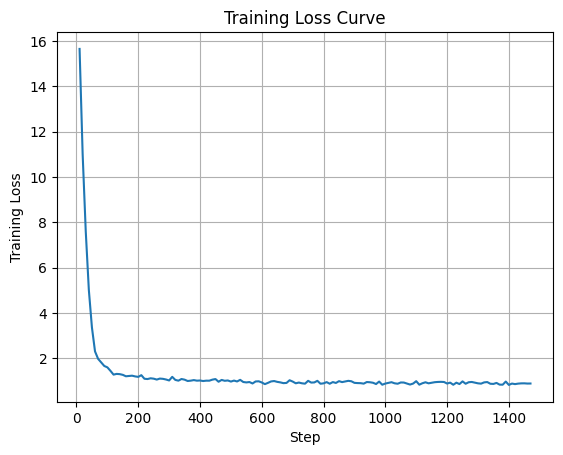

In [2]:
import json
import matplotlib.pyplot as plt

# 讀 trainer_state.json
with open("t5_finetuning_record/trainer_state.json", "r") as f:
    state = json.load(f)

log_history = state["log_history"]

# 抓 loss & step
steps = [entry["step"] for entry in log_history if "loss" in entry]
losses = [entry["loss"] for entry in log_history if "loss" in entry]

plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()